In [1]:
from __future__ import division
import h5py
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.utils import np_utils
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
np.random.seed(1234)

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
Using Theano backend.
Using gpu device 0: GeForce GTX 580 (CNMeM is disabled, cuDNN not available)


In [2]:
fname = "sequences_30_EURUSD_GBPUSD_EURGBP_2012.h5"

In [3]:
with h5py.File(fname, 'r') as f:
    sequences = f['sequences'][...]

In [4]:
n_categories=5
train_rows = int(0.9 * sequences.shape[0])
dev_rows = int(0.1 * sequences.shape[0])

print "train rows", train_rows, "dev rows", dev_rows
train = sequences[:train_rows, :]
dev = sequences[train_rows:train_rows+dev_rows, :]
print "train shape", train.shape
print "dev shape", dev.shape

np.random.shuffle(train)
X_train = train[:, :-1]
y_train = train[:,-1,:][:,0] # first sym's return
y_train = y_train - y_train.mean() 
Y_train = np_utils.to_categorical(pd.qcut(y_train,n_categories, labels=False))

X_dev = dev[:, :-1]
y_dev = dev[:, -1,:][:,0]
Y_dev = np_utils.to_categorical(pd.qcut(y_dev,n_categories, labels=False))

print "X_train", X_train.shape
print "X_dev", X_dev.shape

print "y_train", y_train.shape
print "Y_train", Y_train.shape

print "Y_dev", Y_dev.shape

print "Y_train.mean", Y_train.mean()
print "Y_dev.mean", Y_dev.mean()

train rows 44671 dev rows 4963
train shape (44671, 30, 3)
dev shape (4963, 30, 3)
X_train (44671, 29, 3)
X_dev (4963, 29, 3)
y_train (44671,)
Y_train (44671, 5)
Y_dev (4963, 5)
Y_train.mean 0.2
Y_dev.mean 0.2


In [5]:
# note if X contains 1 dimensional samples maybe just need 1 here, rather than X_train.shape[2]
n_features = X_train.shape[2]

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], n_features))
X_dev = np.reshape(X_dev, (X_dev.shape[0], X_dev.shape[1], n_features))

In [6]:
print X_train.shape
print X_dev.shape

(44671, 29, 3)
(4963, 29, 3)


In [7]:
start = time.time()

model = Sequential()
model.add(LSTM(
            input_dim=n_features,
            output_dim=100,
            return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100,return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(output_dim=n_categories))
model.add(Activation("softmax"))

model.compile(loss='categorical_crossentropy', optimizer='adam')

#model.compile(loss="mse", optimizer="adam")
print "model construct and compile time : ", time.time() - start

model construct and compile time :  0.364592790604


In [16]:
%%time 
epochs=50
batch_size=2048
hist=model.fit(
    X_train, Y_train,
    batch_size=batch_size, nb_epoch=epochs, validation_split=0.05)
hist.history

Train on 42437 samples, validate on 2234 samples
Epoch 1/50
42437/42437 [==============================] - 15s - loss: 1.5320 - val_loss: 1.5422

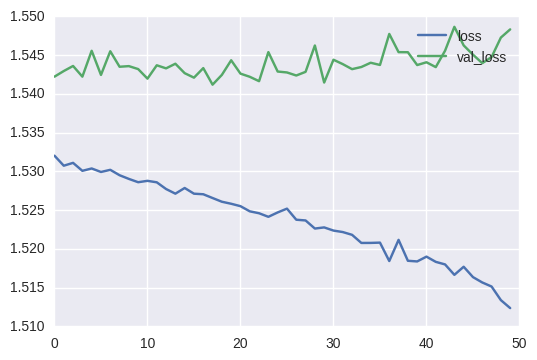

In [17]:
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend()

In [18]:
len(X_dev)

4963

In [19]:
pred = model.predict(X_dev)
truth = Y_dev

pred_class = np_utils.categorical_probas_to_classes(pred)
true_class = np_utils.categorical_probas_to_classes(truth)

(array([ 1433.,     0.,   875.,     0.,     0.,  1040.,     0.,   415.,
            0.,  1200.]),
 array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ,  2.4,  2.8,  3.2,  3.6,  4. ]),
 <a list of 10 Patch objects>)

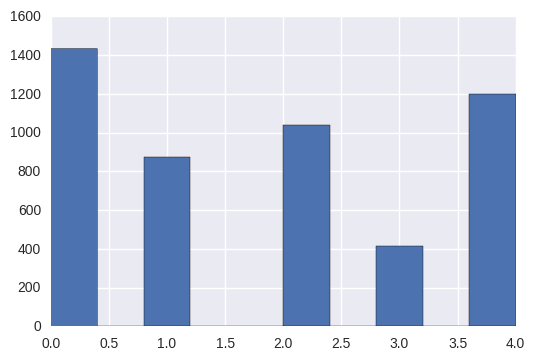

In [20]:
plt.hist(pred_class)

In [21]:
Y_dev.shape

(4963, 5)

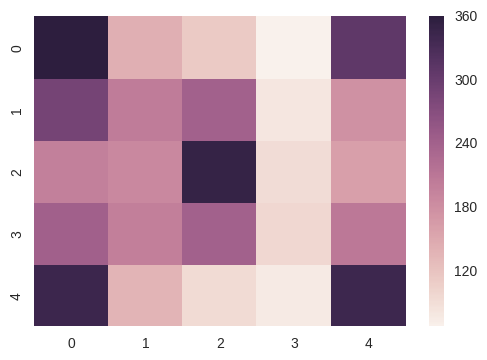

In [22]:
sns.heatmap(confusion_matrix(true_class, pred_class))

In [23]:
print confusion_matrix(true_class, pred_class)
print "acc",accuracy_score(true_class, pred_class)
print "f1", f1_score(true_class, pred_class, average='weighted')
for l in range(5):
    print "f1:",l,f1_score(true_class, pred_class, average='weighted', labels=[l])


[[360 143 113  68 309]
 [288 204 241  81 178]
 [199 190 350  92 162]
 [243 200 242  98 209]
 [343 138  94  76 342]]
acc 0.272818859561
f1 0.262201741173
f1: 0 0.296784830998
f1: 1 0.218532404928
f1: 2 0.344318740777
f1: 3 0.139303482587
f1: 4 0.311901504788


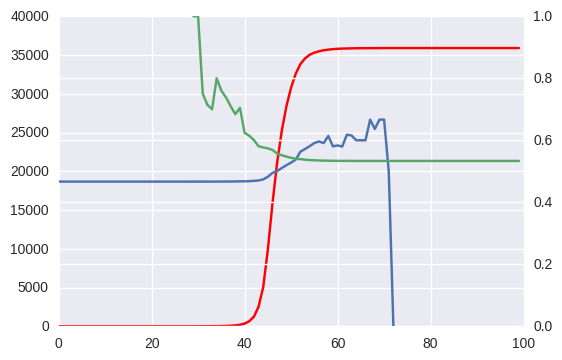

In [142]:
fig, ax1 = plt.subplots()
xs = []
hs = []
ls = []
cs = []
for i in range(100):
    idx = p > i/100
    hi_frac =  np.mean(truth[idx])
    lo_frac =  np.mean(truth[~ idx] == 0)
    hi_count = len(truth[idx])
    lo_count = len(truth[~ idx])
    xs.append(i)
    hs.append(hi_frac)
    ls.append(lo_frac)
    cs.append(lo_count)
ax1.plot(xs,cs, 'r')
ax2 = ax1.twinx()
ax2.plot(xs,hs)
ax2.plot(xs,ls)

    

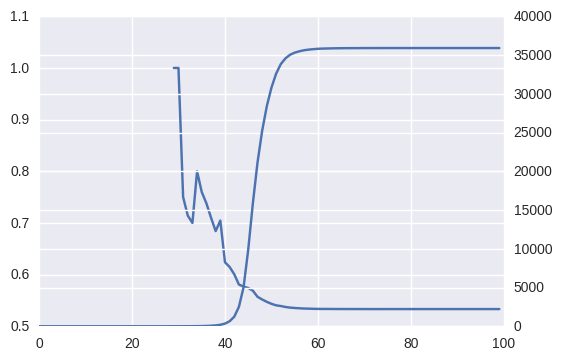

In [133]:
fig, ax1 = plt.subplots()
xs = []
ys = []
cs = []
for i in range(100):
    idx = p < i/100
    frac =  np.mean(truth[idx] == 0)
    count = len(truth[idx])
    xs.append(i)
    ys.append(frac)
    cs.append(count)
ax1.plot(xs,ys)
ax2 = ax1.twinx()
ax2.plot(xs,cs)

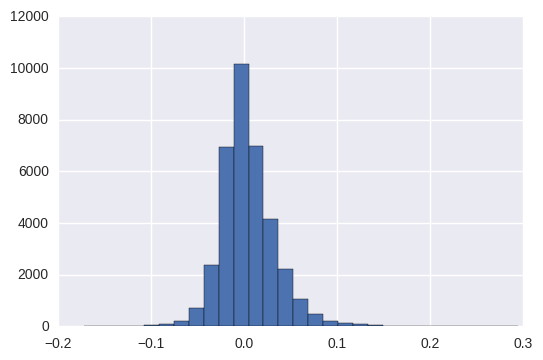

In [73]:
(p-p.median()).hist(bins=30)

In [187]:
y= pd.Series(train[:, -1])
((y < -0.1*y.std()) * 1.0).mean()

0.41783946017840851

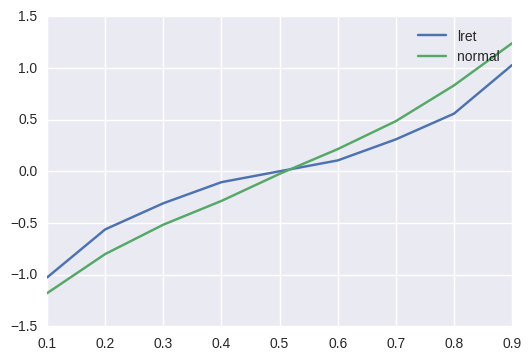

In [195]:
(y.quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])/y.std()).transpose().plot(label='lret')
pd.Series(np.random.randn(1000)).quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]).transpose().plot(label='normal')
plt.legend()

In [197]:
y.quantile([.2,0.4,0.6,0.8])

0.2   -0.052174
0.4   -0.009773
0.6    0.009752
0.8    0.051750
dtype: float64

In [209]:
np_utils.to_categorical(pd.qcut(y,3, labels=False))

array([[ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       ..., 
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.]])

In [214]:
y_dev

array([0, 1, 1, ..., 1, 1, 0])